In [1]:
from ISUP_test.Functions.sklearn_plots import *

import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import cv2
import os
import time
import multiprocessing
import gc
import warnings

from collections import Counter
from joblib import Parallel, delayed, dump, load
from shapely.geometry.polygon import Polygon
from functions import *

from skimage import data
from skimage import morphology
from skimage import measure
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern, peak_local_max, canny, hog
from skimage.io import imread, imshow
from skimage.color import rgb2hed, hed2rgb, rgb2gray, label2rgb, gray2rgb, rgb2lab, rgb2yuv
from skimage.util import crop, img_as_ubyte, img_as_float, invert, view_as_blocks
from skimage.filters import threshold_otsu, threshold_local, rank, sobel
from skimage.segmentation import clear_border
from skimage.exposure import adjust_gamma, rescale_intensity
from skimage.transform import match_histograms

from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit,ShuffleSplit,cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.datasets import load_sample_image
from sklearn.pipeline import make_pipeline

from scipy.interpolate import UnivariateSpline
from scipy import ndimage as ndi
from scipy.spatial import Delaunay, ConvexHull

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib.colors import LinearSegmentedColormap
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white','navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white','saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet','white'])

In [2]:
image = imread('/home/tien/Documents/projets/histopathology/ISUP_test/ISUP_images/GS_33/207_20X_2.jpg') # 549_20X, 207_20X_2
ref = imread('/home/tien/Documents/projets/histopathology/ISUP_test/ISUP_images/GS_34/281_20X.jpg')
contours, labels, props, nuclei_mask, eosin_mask, lumen_mask = detect_nuclei(image, ref)

/home/tien/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/tien/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [3]:
# Une map contenant l'emplacement des centroïdes.
# Elle sera utilisée dans le comptage de noyaux voisins dans chaque itération de "patch" de (50 x 50 pixels)
centroids = np.zeros((image.shape[0], image.shape[1]))
for i in range(len(props)):
    r, c = props[i].centroid
    centroids[int(r), int(c)] = 1

height, width = centroids.shape[0], centroids.shape[1] # rows and columns
patch_height, patch_width = np.max([x for x in factors(height) if 200 <= x <= 350]), np.max([x for x in factors(width) if 200 <= x <= 350])
patch_shape = (patch_height, patch_width) # shape = (# patch rows, # patch columns, # row pixels/patch, # column pixels/patch)
patch_area = patch_height*patch_width

patches_centroids = view_as_blocks(centroids, patch_shape)
patches_nuclei = view_as_blocks(nuclei_mask, patch_shape)
patches_lumen = view_as_blocks(lumen_mask, patch_shape)
patches_eosin = view_as_blocks(eosin_mask, patch_shape)

num_nuclei_densities = []
nuclei_densities = []
lumen_densities = []
eosin_densities = []

for i in range(patches_centroids.shape[0]) :
    for j in range(patches_centroids.shape[1]) :
        lumen_percentage = np.sum(patches_lumen[i][j])/patch_area
        if lumen_percentage <= 0.4 :
            num_nuclei_densities.append(np.sum(patches_centroids[i][j])/patch_area)
            nuclei_densities.append(np.sum(patches_nuclei[i][j])/patch_area)
            lumen_densities.append(np.sum(patches_lumen[i][j])/patch_area)
            eosin_densities.append(np.sum(patches_eosin[i][j])/patch_area)

num_nuclei_densities_stats = np.array([np.amin(num_nuclei_densities), np.amax(num_nuclei_densities), np.mean(num_nuclei_densities), np.var(num_nuclei_densities)])
nuclei_densities_stats = np.array([np.amin(nuclei_densities), np.amax(nuclei_densities), np.mean(nuclei_densities), np.var(nuclei_densities)])
lumen_densities_stats = np.array([np.amin(lumen_densities), np.amax(lumen_densities), np.mean(lumen_densities), np.var(lumen_densities)])
eosin_densities_stats = np.array([np.amin(eosin_densities), np.amax(eosin_densities), np.mean(eosin_densities), np.var(eosin_densities)])

densities_features = np.hstack((num_nuclei_densities_stats, nuclei_densities_stats, lumen_densities_stats, eosin_densities_stats)) # 16 features

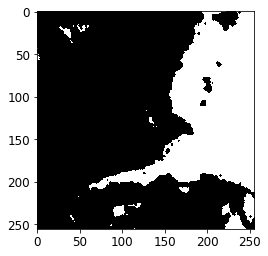

In [10]:
%matplotlib inline
plt.figure(2)
plt.imshow(patches_lumen[6][5], cmap=plt.cm.gray)

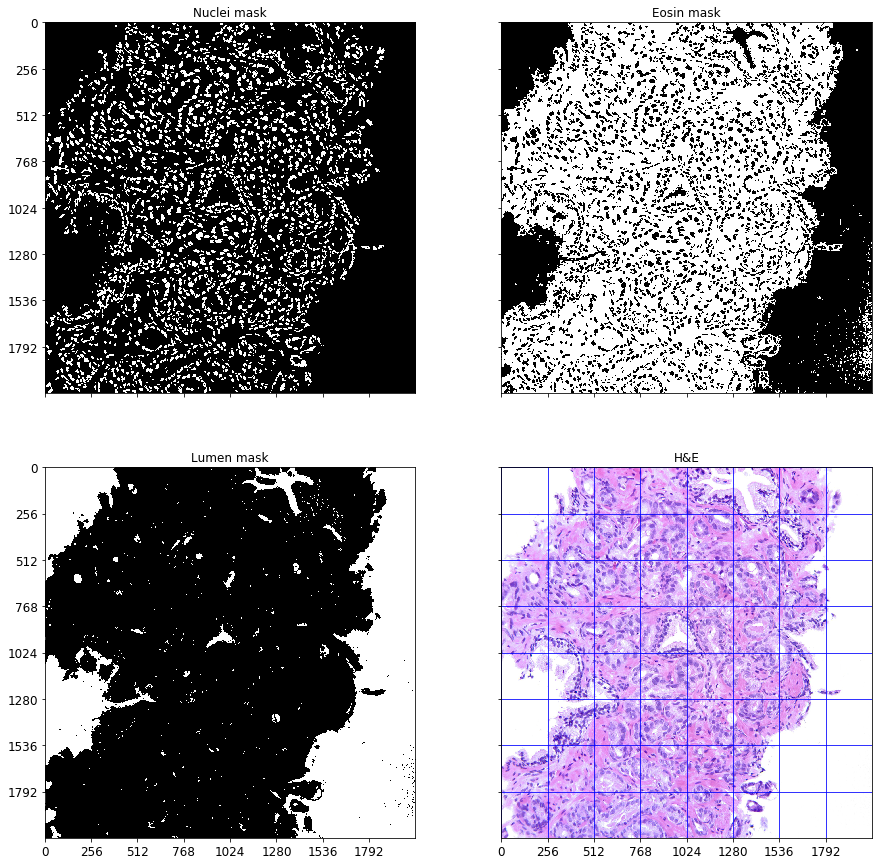

In [5]:
f, ax = plt.subplots(2,2,figsize=(15,15), sharex=True,sharey=True)
ax = ax.ravel()

ax[0].imshow(nuclei_mask, cmap=plt.cm.gray)
ax[0].set_title('Nuclei mask')

ax[1].imshow(eosin_mask, cmap=plt.cm.gray)
ax[1].set_title('Eosin mask')

ax[2].imshow(lumen_mask, cmap=plt.cm.gray)
ax[2].set_title('Lumen mask')

ax[3].imshow(image)
ax[3].set_title('H&E')
ax[3].set_xticks(np.arange(0,2048,256))
ax[3].set_yticks(np.arange(0,2048,256))
ax[3].grid(color='b')

plt.show()

### Calculate densities on whole images features from props and masks files (no patches)

In [5]:
nuclei_area = np.sum(nuclei_mask)

In [6]:
area_image = lumen_mask.shape[0]*lumen_mask.shape[1]
tissu_area = np.where(lumen_mask == 0)[0].shape[0]
#tissu_ratio = tissu_area/area_image
density = nuclei_area/tissu_area

In [14]:
np.where(lumen_mask == 0)[0].shape, np.where(lumen_mask == 0)[1].shape

((3047719,), (3047719,))

In [7]:
density

0.20454116668892375

In [8]:
nuclei_area/np.sum(eosin_mask)

0.24648042695902406